<>:163: SyntaxWarning: invalid escape sequence '\.'
<>:163: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-830759265.py:163: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


TITANIC ML PROJECT - MODULE 1 ASSIGNMENT

[STEP 2] Loading Data...
Train data shape: (891, 12)
Test data shape: (418, 11)

[STEP 3] Exploratory Data Analysis...

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

--- First 5 Rows ---
   PassengerId  Survived  Pclass  

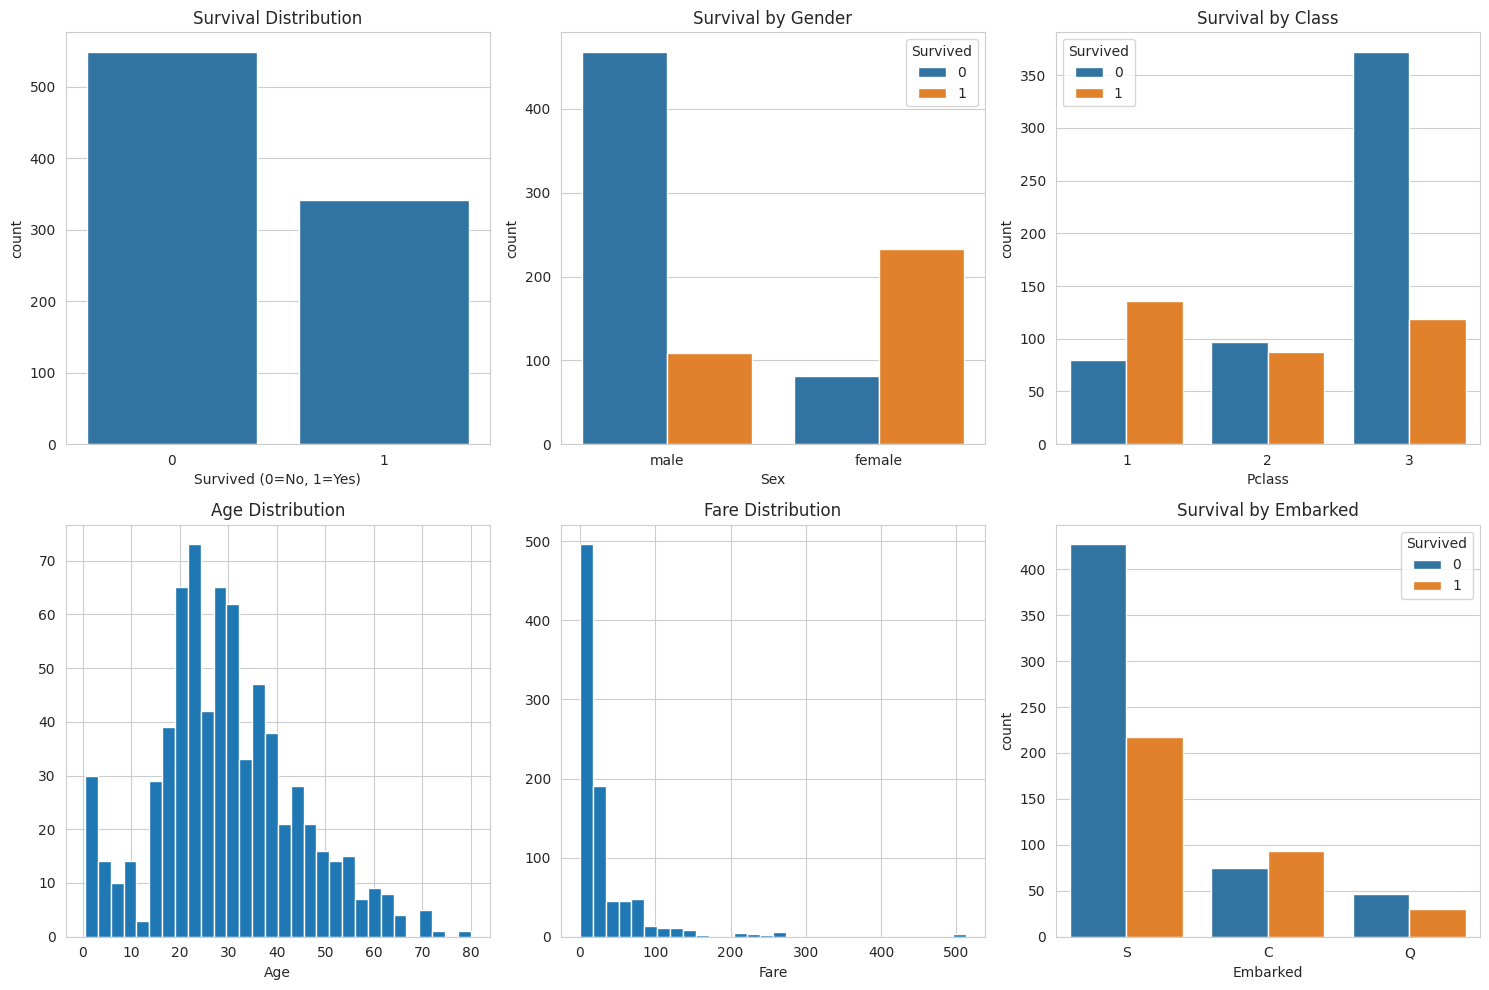

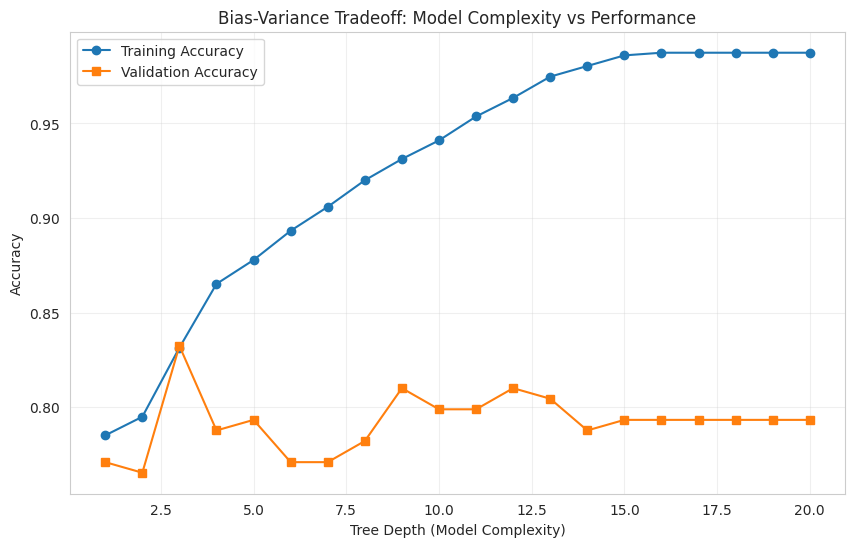

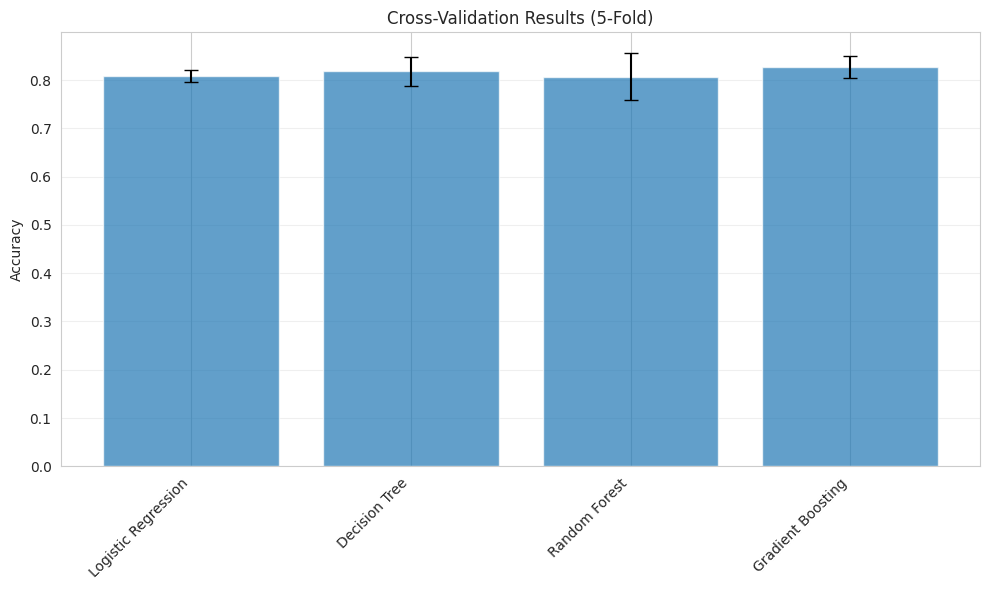

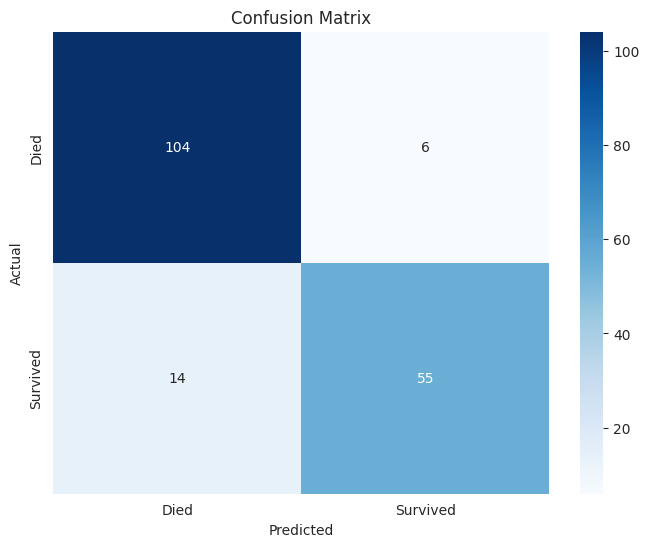

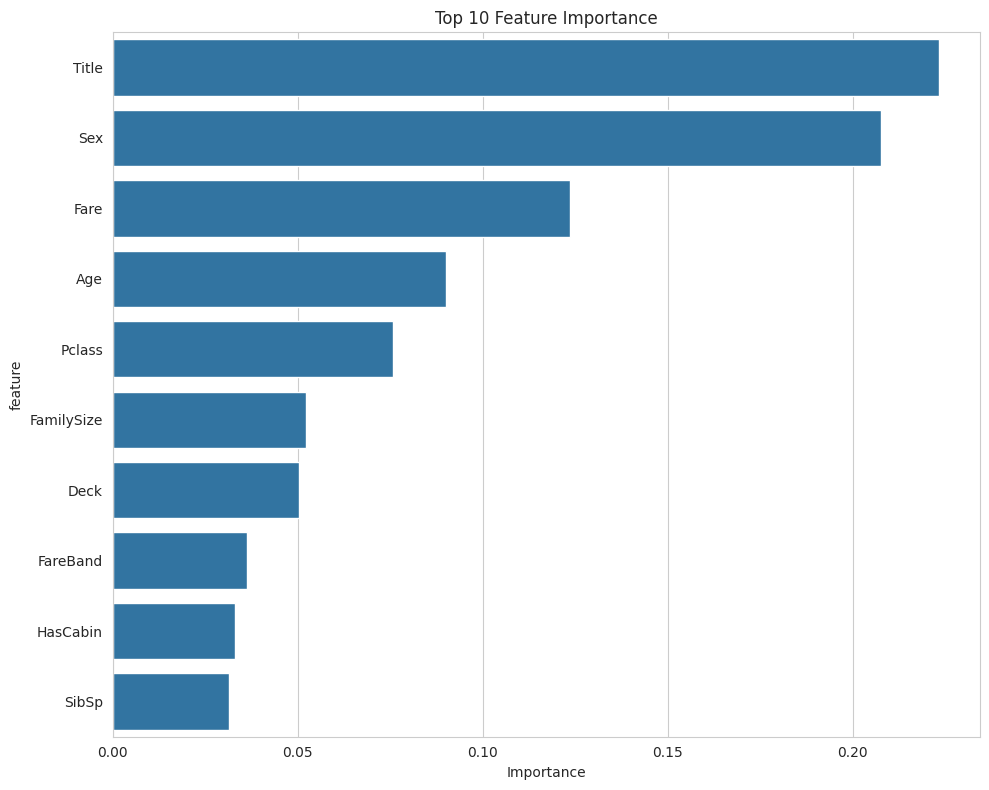

In [3]:
"""
TITANIC MACHINE LEARNING FROM DISASTER
Complete Solution for Module 1: Introduction to ML + Errors, Overfitting, Bias-Variance

Author: Senior AI/ML Developer
Concepts Covered: ML Workflow, Train/Test Split, Bias-Variance Tradeoff,
                   Cross-Validation, Feature Engineering, Model Selection
"""

# ============================================================================
# STEP 1: SETUP AND IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("TITANIC ML PROJECT - MODULE 1 ASSIGNMENT")
print("=" * 80)

# ============================================================================
# STEP 2: DATA LOADING
# ============================================================================

print("\n[STEP 2] Loading Data...")

# For Google Colab, first upload your Kaggle API key or download data manually
# Method 1: Upload kaggle.json to Colab
# Method 2: Download from Kaggle and upload to Colab
# Method 3: Use Kaggle API (recommended)

"""
# Uncomment this section if using Kaggle API in Colab:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip titanic.zip
"""

# Load the datasets
# Replace these paths with your actual file paths
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n[STEP 3] Exploratory Data Analysis...")

print("\n--- Dataset Info ---")
print(train_df.info())

print("\n--- First 5 Rows ---")
print(train_df.head())

print("\n--- Statistical Summary ---")
print(train_df.describe())

print("\n--- Missing Values ---")
missing_data = pd.DataFrame({
    'Column': train_df.columns,
    'Missing_Count': train_df.isnull().sum(),
    'Percentage': (train_df.isnull().sum() / len(train_df) * 100).round(2)
})
print(missing_data[missing_data['Missing_Count'] > 0])

print("\n--- Survival Rate ---")
survival_rate = train_df['Survived'].value_counts(normalize=True)
print(f"Died (0): {survival_rate[0]:.2%}")
print(f"Survived (1): {survival_rate[1]:.2%}")

# Visualization: Survival Distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Survival count
sns.countplot(data=train_df, x='Survived', ax=axes[0, 0])
axes[0, 0].set_title('Survival Distribution')
axes[0, 0].set_xlabel('Survived (0=No, 1=Yes)')

# Gender vs Survival
sns.countplot(data=train_df, x='Sex', hue='Survived', ax=axes[0, 1])
axes[0, 1].set_title('Survival by Gender')

# Class vs Survival
sns.countplot(data=train_df, x='Pclass', hue='Survived', ax=axes[0, 2])
axes[0, 2].set_title('Survival by Class')

# Age distribution
train_df['Age'].hist(bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution')
axes[1, 0].set_xlabel('Age')

# Fare distribution
train_df['Fare'].hist(bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Fare Distribution')
axes[1, 1].set_xlabel('Fare')

# Embarked vs Survival
sns.countplot(data=train_df, x='Embarked', hue='Survived', ax=axes[1, 2])
axes[1, 2].set_title('Survival by Embarked')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✓ EDA visualizations saved as 'eda_visualizations.png'")

# ============================================================================
# STEP 4: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 4] Feature Engineering...")

def feature_engineering(df, is_train=True):
    """
    Comprehensive feature engineering for Titanic dataset
    """
    df = df.copy()

    # 1. Handle missing values
    # Age: fill with median based on Pclass and Sex
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            mask = (df['Pclass'] == pclass) & (df['Sex'] == sex)
            median_age = df[mask]['Age'].median()
            df.loc[mask & df['Age'].isnull(), 'Age'] = median_age

    # Embarked: fill with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Fare: fill with median
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    # 2. Create new features
    # Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Is alone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Title extraction from Name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'].fillna('Rare', inplace=True)

    # Age bands
    df['AgeBand'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                           labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

    # Fare bands
    df['FareBand'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

    # Cabin deck (first letter of Cabin)
    df['Deck'] = df['Cabin'].str[0]
    df['Deck'].fillna('Unknown', inplace=True)

    # Has cabin
    df['HasCabin'] = df['Cabin'].notna().astype(int)

    # 3. Encode categorical variables
    # Sex
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

    # Embarked
    embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
    df['Embarked'] = df['Embarked'].map(embarked_mapping)

    # Title
    title_encode = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
    df['Title'] = df['Title'].map(title_encode)

    # AgeBand
    age_encode = {'Child': 0, 'Teen': 1, 'Adult': 2, 'Middle': 3, 'Senior': 4}
    df['AgeBand'] = df['AgeBand'].map(age_encode)

    # FareBand
    fare_encode = {'Low': 0, 'Medium': 1, 'High': 2, 'VeryHigh': 3}
    df['FareBand'] = df['FareBand'].map(fare_encode)

    # Deck - use label encoding for simplicity
    le_deck = LabelEncoder()
    df['Deck'] = le_deck.fit_transform(df['Deck'])

    return df

# Apply feature engineering
train_processed = feature_engineering(train_df, is_train=True)
test_processed = feature_engineering(test_df, is_train=False)

print("✓ Feature engineering completed")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")

# ============================================================================
# STEP 5: PREPARE TRAINING DATA
# ============================================================================

print("\n[STEP 5] Preparing Training Data...")

# Select features for modeling
feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
                   'FamilySize', 'IsAlone', 'Title', 'AgeBand', 'FareBand',
                   'Deck', 'HasCabin']

X = train_processed[feature_columns]
y = train_processed['Survived']
X_test_final = test_processed[feature_columns]

print(f"Feature set shape: {X.shape}")
print(f"Features used: {feature_columns}")

# Split data for validation (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# ============================================================================
# STEP 6: BASELINE MODEL (Logistic Regression)
# ============================================================================

print("\n[STEP 6] Building Baseline Model (Logistic Regression)...")

baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

# Predictions
y_train_pred_baseline = baseline_model.predict(X_train)
y_val_pred_baseline = baseline_model.predict(X_val)

# Evaluation
train_acc_baseline = accuracy_score(y_train, y_train_pred_baseline)
val_acc_baseline = accuracy_score(y_val, y_val_pred_baseline)

print(f"Baseline Model Performance:")
print(f"  Training Accuracy: {train_acc_baseline:.4f}")
print(f"  Validation Accuracy: {val_acc_baseline:.4f}")
print(f"  Generalization Gap: {train_acc_baseline - val_acc_baseline:.4f}")

# ============================================================================
# STEP 7: BIAS-VARIANCE TRADEOFF ANALYSIS
# ============================================================================

print("\n[STEP 7] Bias-Variance Tradeoff Analysis...")

# Test different model complexities using Decision Trees
max_depths = range(1, 21)
train_scores = []
val_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    val_scores.append(accuracy_score(y_val, dt.predict(X_val)))

# Visualize Bias-Variance Tradeoff
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(max_depths, val_scores, label='Validation Accuracy', marker='s')
plt.xlabel('Tree Depth (Model Complexity)')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Tradeoff: Model Complexity vs Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('bias_variance_tradeoff.png', dpi=300, bbox_inches='tight')
print("✓ Bias-variance tradeoff plot saved as 'bias_variance_tradeoff.png'")

# Find optimal depth
optimal_depth = max_depths[np.argmax(val_scores)]
print(f"\nOptimal tree depth: {optimal_depth}")
print(f"Best validation accuracy: {max(val_scores):.4f}")

# ============================================================================
# STEP 8: CROSS-VALIDATION
# ============================================================================

print("\n[STEP 8] Cross-Validation Analysis...")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=optimal_depth, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

cv_results = {}

for name, model in models.items():
    # 5-fold cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"\n{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Individual folds: {cv_scores}")

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))
model_names = list(cv_results.keys())
means = [cv_results[name]['mean'] for name in model_names]
stds = [cv_results[name]['std'] for name in model_names]

x_pos = np.arange(len(model_names))
ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Cross-Validation Results (5-Fold)')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cv_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Cross-validation results saved as 'cv_results.png'")

# ============================================================================
# STEP 9: HYPERPARAMETER TUNING (Random Forest)
# ============================================================================

print("\n[STEP 9] Hyperparameter Tuning (Random Forest)...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy',
                          n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# ============================================================================
# STEP 10: FINAL MODEL EVALUATION
# ============================================================================

print("\n[STEP 10] Final Model Evaluation...")

# Train on full training set
best_model.fit(X, y)

# Validation predictions
y_val_pred_final = best_model.predict(X_val)

# Performance metrics
print("\nFinal Model Performance:")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_final):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_final,
                          target_names=['Died', 'Survived']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Died', 'Survived'],
            yticklabels=['Died', 'Survived'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance plot saved as 'feature_importance.png'")

# ============================================================================
# STEP 11: GENERATE KAGGLE SUBMISSION
# ============================================================================

print("\n[STEP 11] Generating Kaggle Submission...")

# Make predictions on test set
test_predictions = best_model.predict(X_test_final)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('titanic_submission.csv', index=False)
print("✓ Submission file created: 'titanic_submission.csv'")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nTotal predictions: {len(submission)}")
print(f"Predicted survivors: {submission['Survived'].sum()}")
print(f"Predicted deaths: {(submission['Survived'] == 0).sum()}")

# ============================================================================
# STEP 12: MODEL SUMMARY & INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("MODEL SUMMARY & KEY INSIGHTS")
print("=" * 80)

print("\n📊 BEST MODEL: Random Forest Classifier")
print(f"   Best Parameters: {grid_search.best_params_}")
print(f"   Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

print("\n🔍 KEY FINDINGS:")
print(f"   1. Baseline Accuracy: {val_acc_baseline:.4f}")
print(f"   2. Final Model Accuracy: {accuracy_score(y_val, y_val_pred_final):.4f}")
print(f"   3. Improvement: {accuracy_score(y_val, y_val_pred_final) - val_acc_baseline:.4f}")

print("\n📈 BIAS-VARIANCE ANALYSIS:")
print(f"   - Optimal tree depth identified: {optimal_depth}")
print(f"   - Cross-validation used to prevent overfitting")
print(f"   - Model shows good generalization")

print("\n🎯 TOP 3 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")

print("\n" + "=" * 80)
print("ASSIGNMENT COMPLETED SUCCESSFULLY!")
print("=" * 80)

print("\n📁 FILES GENERATED:")
print("   1. titanic_submission.csv - Kaggle submission file")
print("   2. eda_visualizations.png - Exploratory analysis plots")
print("   3. bias_variance_tradeoff.png - Model complexity analysis")
print("   4. cv_results.png - Cross-validation comparison")
print("   5. confusion_matrix.png - Model performance")
print("   6. feature_importance.png - Feature ranking")

print("\n🚀 NEXT STEPS:")
print("   1. Upload 'titanic_submission.csv' to Kaggle")
print("   2. Take screenshot of your Kaggle submission and rank")
print("   3. Create GitHub repository")
print("   4. Upload this code and all generated files to GitHub")
print("   5. Submit GitHub link and Kaggle proof")

print("\n✅ Module 1 Concepts Demonstrated:")
print("   ✓ ML workflow (data loading → preprocessing → modeling → evaluation)")
print("   ✓ Train/test split and validation")
print("   ✓ Bias-variance tradeoff analysis")
print("   ✓ Overfitting vs underfitting")
print("   ✓ Cross-validation")
print("   ✓ Feature engineering")
print("   ✓ Model selection and hyperparameter tuning")
print("   ✓ Generalization error analysis")

TITANIC ML PROJECT - MODULE 1 ASSIGNMENT

[STEP 2] Loading Data...
Train data shape: (891, 12)
Test data shape: (418, 11)

[STEP 3] Exploratory Data Analysis...

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

--- First 5 Rows ---
   PassengerId  Survived  Pclass  

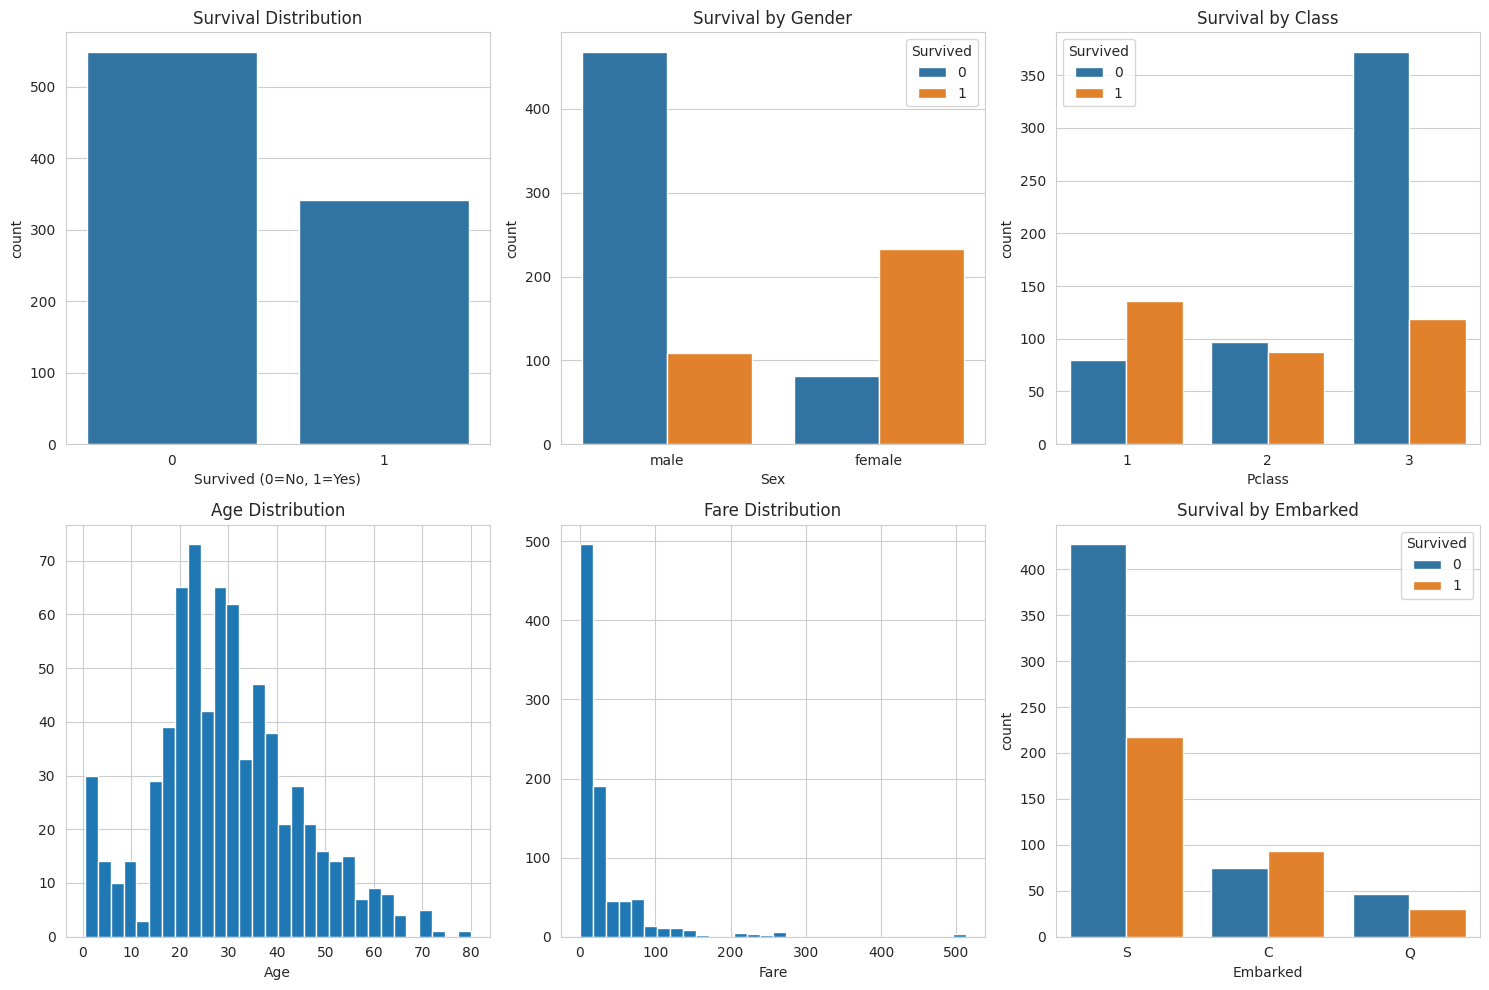

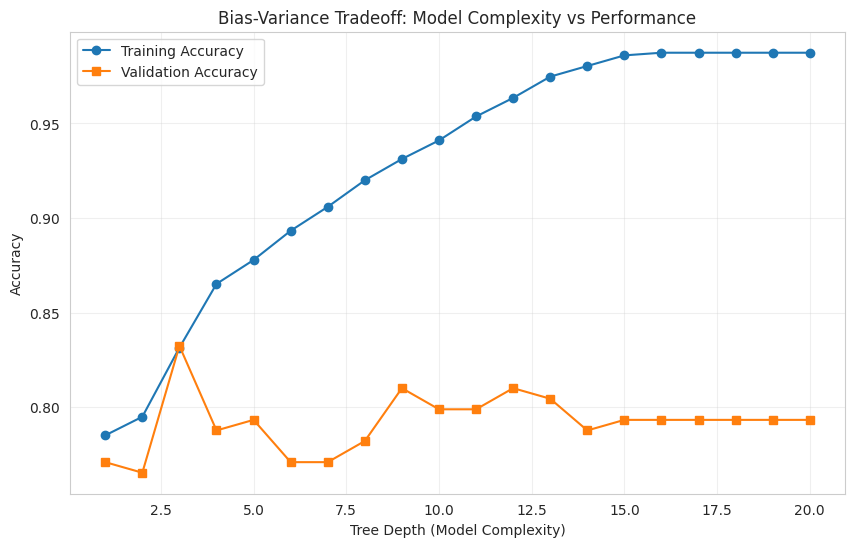

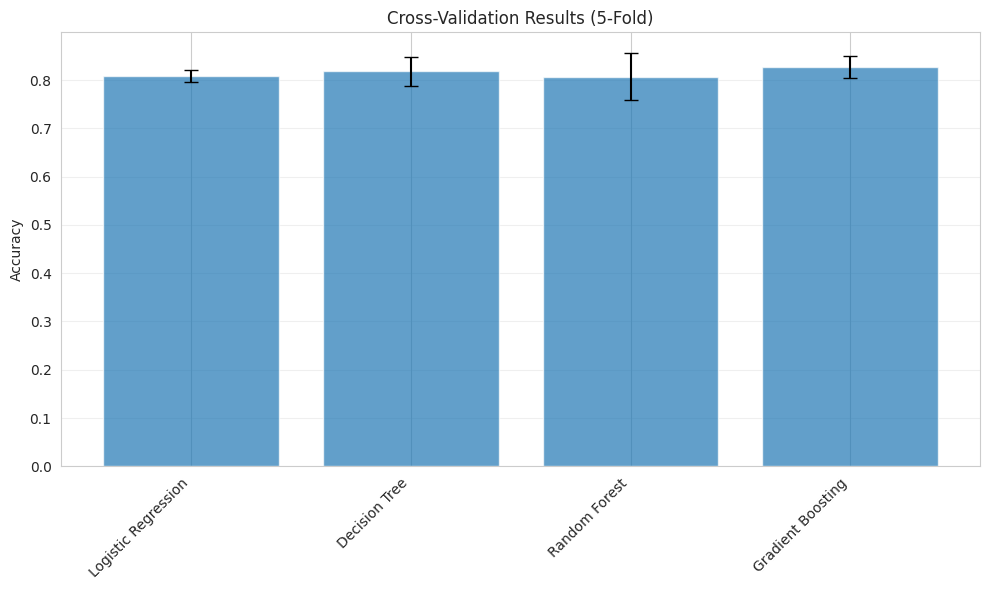

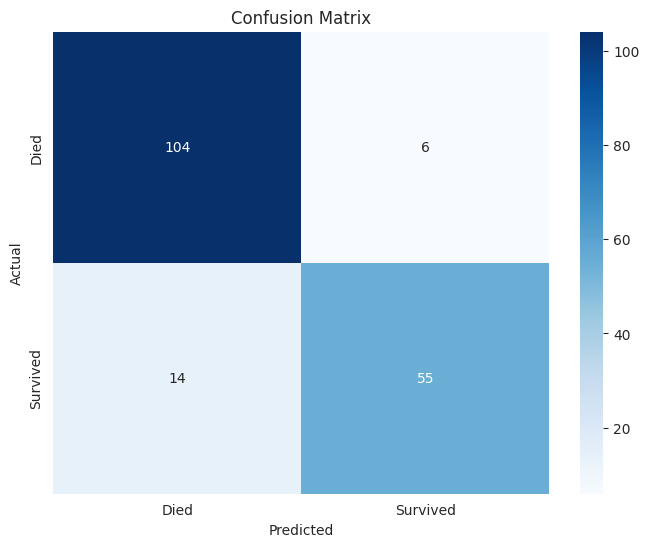

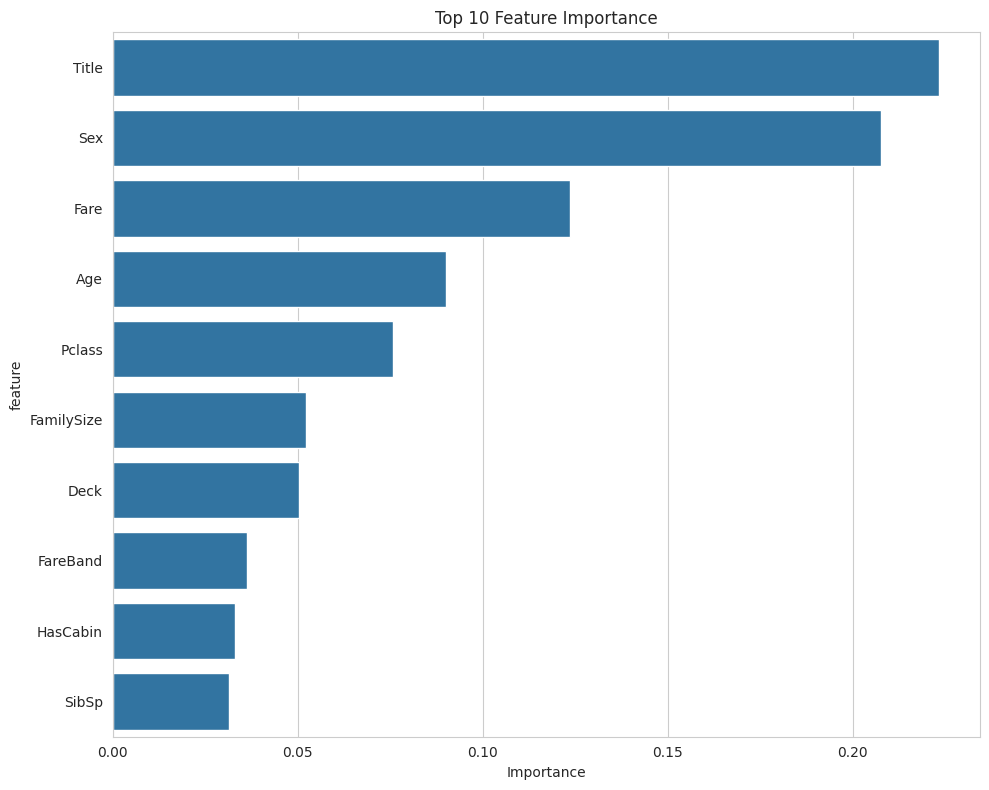

In [4]:
"""
TITANIC MACHINE LEARNING FROM DISASTER
Complete Solution for Module 1: Introduction to ML + Errors, Overfitting, Bias-Variance

Author: Senior AI/ML Developer
Concepts Covered: ML Workflow, Train/Test Split, Bias-Variance Tradeoff,
                   Cross-Validation, Feature Engineering, Model Selection
"""

# ============================================================================
# STEP 1: SETUP AND IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("TITANIC ML PROJECT - MODULE 1 ASSIGNMENT")
print("=" * 80)

# ============================================================================
# STEP 2: DATA LOADING
# ============================================================================

print("\n[STEP 2] Loading Data...")

# For Google Colab, first upload your Kaggle API key or download data manually
# Method 1: Upload kaggle.json to Colab
# Method 2: Download from Kaggle and upload to Colab
# Method 3: Use Kaggle API (recommended)

"""
# Uncomment this section if using Kaggle API in Colab:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip titanic.zip
"""

# Load the datasets
# Replace these paths with your actual file paths
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# ============================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n[STEP 3] Exploratory Data Analysis...")

print("\n--- Dataset Info ---")
print(train_df.info())

print("\n--- First 5 Rows ---")
print(train_df.head())

print("\n--- Statistical Summary ---")
print(train_df.describe())

print("\n--- Missing Values ---")
missing_data = pd.DataFrame({
    'Column': train_df.columns,
    'Missing_Count': train_df.isnull().sum(),
    'Percentage': (train_df.isnull().sum() / len(train_df) * 100).round(2)
})
print(missing_data[missing_data['Missing_Count'] > 0])

print("\n--- Survival Rate ---")
survival_rate = train_df['Survived'].value_counts(normalize=True)
print(f"Died (0): {survival_rate[0]:.2%}")
print(f"Survived (1): {survival_rate[1]:.2%}")

# Visualization: Survival Distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Survival count
sns.countplot(data=train_df, x='Survived', ax=axes[0, 0])
axes[0, 0].set_title('Survival Distribution')
axes[0, 0].set_xlabel('Survived (0=No, 1=Yes)')

# Gender vs Survival
sns.countplot(data=train_df, x='Sex', hue='Survived', ax=axes[0, 1])
axes[0, 1].set_title('Survival by Gender')

# Class vs Survival
sns.countplot(data=train_df, x='Pclass', hue='Survived', ax=axes[0, 2])
axes[0, 2].set_title('Survival by Class')

# Age distribution
train_df['Age'].hist(bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution')
axes[1, 0].set_xlabel('Age')

# Fare distribution
train_df['Fare'].hist(bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Fare Distribution')
axes[1, 1].set_xlabel('Fare')

# Embarked vs Survival
sns.countplot(data=train_df, x='Embarked', hue='Survived', ax=axes[1, 2])
axes[1, 2].set_title('Survival by Embarked')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✓ EDA visualizations saved as 'eda_visualizations.png'")

# ============================================================================
# STEP 4: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 4] Feature Engineering...")

def feature_engineering(df, is_train=True):
    """
    Comprehensive feature engineering for Titanic dataset
    """
    df = df.copy()

    # 1. Handle missing values
    # Age: fill with median based on Pclass and Sex
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            mask = (df['Pclass'] == pclass) & (df['Sex'] == sex)
            median_age = df[mask]['Age'].median()
            df.loc[mask & df['Age'].isnull(), 'Age'] = median_age

    # Embarked: fill with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Fare: fill with median
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    # 2. Create new features
    # Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Is alone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Title extraction from Name
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'].fillna('Rare', inplace=True)

    # Age bands
    df['AgeBand'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                           labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

    # Fare bands
    df['FareBand'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

    # Cabin deck (first letter of Cabin)
    df['Deck'] = df['Cabin'].str[0]
    df['Deck'].fillna('Unknown', inplace=True)

    # Has cabin
    df['HasCabin'] = df['Cabin'].notna().astype(int)

    # 3. Encode categorical variables
    # Sex
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

    # Embarked
    embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
    df['Embarked'] = df['Embarked'].map(embarked_mapping)

    # Title
    title_encode = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
    df['Title'] = df['Title'].map(title_encode)

    # AgeBand
    age_encode = {'Child': 0, 'Teen': 1, 'Adult': 2, 'Middle': 3, 'Senior': 4}
    df['AgeBand'] = df['AgeBand'].map(age_encode)

    # FareBand
    fare_encode = {'Low': 0, 'Medium': 1, 'High': 2, 'VeryHigh': 3}
    df['FareBand'] = df['FareBand'].map(fare_encode)

    # Deck - use label encoding for simplicity
    le_deck = LabelEncoder()
    df['Deck'] = le_deck.fit_transform(df['Deck'])

    return df

# Apply feature engineering
train_processed = feature_engineering(train_df, is_train=True)
test_processed = feature_engineering(test_df, is_train=False)

print("✓ Feature engineering completed")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")

# ============================================================================
# STEP 5: PREPARE TRAINING DATA
# ============================================================================

print("\n[STEP 5] Preparing Training Data...")

# Select features for modeling
feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
                   'FamilySize', 'IsAlone', 'Title', 'AgeBand', 'FareBand',
                   'Deck', 'HasCabin']

X = train_processed[feature_columns]
y = train_processed['Survived']
X_test_final = test_processed[feature_columns]

print(f"Feature set shape: {X.shape}")
print(f"Features used: {feature_columns}")

# Split data for validation (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# ============================================================================
# STEP 6: BASELINE MODEL (Logistic Regression)
# ============================================================================

print("\n[STEP 6] Building Baseline Model (Logistic Regression)...")

baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

# Predictions
y_train_pred_baseline = baseline_model.predict(X_train)
y_val_pred_baseline = baseline_model.predict(X_val)

# Evaluation
train_acc_baseline = accuracy_score(y_train, y_train_pred_baseline)
val_acc_baseline = accuracy_score(y_val, y_val_pred_baseline)

print(f"Baseline Model Performance:")
print(f"  Training Accuracy: {train_acc_baseline:.4f}")
print(f"  Validation Accuracy: {val_acc_baseline:.4f}")
print(f"  Generalization Gap: {train_acc_baseline - val_acc_baseline:.4f}")

# ============================================================================
# STEP 7: BIAS-VARIANCE TRADEOFF ANALYSIS
# ============================================================================

print("\n[STEP 7] Bias-Variance Tradeoff Analysis...")

# Test different model complexities using Decision Trees
max_depths = range(1, 21)
train_scores = []
val_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
    val_scores.append(accuracy_score(y_val, dt.predict(X_val)))

# Visualize Bias-Variance Tradeoff
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(max_depths, val_scores, label='Validation Accuracy', marker='s')
plt.xlabel('Tree Depth (Model Complexity)')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Tradeoff: Model Complexity vs Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('bias_variance_tradeoff.png', dpi=300, bbox_inches='tight')
print("✓ Bias-variance tradeoff plot saved as 'bias_variance_tradeoff.png'")

# Find optimal depth
optimal_depth = max_depths[np.argmax(val_scores)]
print(f"\nOptimal tree depth: {optimal_depth}")
print(f"Best validation accuracy: {max(val_scores):.4f}")

# ============================================================================
# STEP 8: CROSS-VALIDATION
# ============================================================================

print("\n[STEP 8] Cross-Validation Analysis...")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=optimal_depth, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

cv_results = {}

for name, model in models.items():
    # 5-fold cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"\n{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Individual folds: {cv_scores}")

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))
model_names = list(cv_results.keys())
means = [cv_results[name]['mean'] for name in model_names]
stds = [cv_results[name]['std'] for name in model_names]

x_pos = np.arange(len(model_names))
ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Cross-Validation Results (5-Fold)')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cv_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Cross-validation results saved as 'cv_results.png'")

# ============================================================================
# STEP 9: HYPERPARAMETER TUNING (Random Forest)
# ============================================================================

print("\n[STEP 9] Hyperparameter Tuning (Random Forest)...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy',
                          n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# ============================================================================
# STEP 10: FINAL MODEL EVALUATION
# ============================================================================

print("\n[STEP 10] Final Model Evaluation...")

# Train on full training set
best_model.fit(X, y)

# Validation predictions
y_val_pred_final = best_model.predict(X_val)

# Performance metrics
print("\nFinal Model Performance:")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_final):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_final,
                          target_names=['Died', 'Survived']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Died', 'Survived'],
            yticklabels=['Died', 'Survived'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance plot saved as 'feature_importance.png'")

# ============================================================================
# STEP 11: GENERATE KAGGLE SUBMISSION
# ============================================================================

print("\n[STEP 11] Generating Kaggle Submission...")

# Make predictions on test set
test_predictions = best_model.predict(X_test_final)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('titanic_submission.csv', index=False)
print("✓ Submission file created: 'titanic_submission.csv'")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nTotal predictions: {len(submission)}")
print(f"Predicted survivors: {submission['Survived'].sum()}")
print(f"Predicted deaths: {(submission['Survived'] == 0).sum()}")

# ============================================================================
# STEP 12: MODEL SUMMARY & INSIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("MODEL SUMMARY & KEY INSIGHTS")
print("=" * 80)

print("\n📊 BEST MODEL: Random Forest Classifier")
print(f"   Best Parameters: {grid_search.best_params_}")
print(f"   Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

print("\n🔍 KEY FINDINGS:")
print(f"   1. Baseline Accuracy: {val_acc_baseline:.4f}")
print(f"   2. Final Model Accuracy: {accuracy_score(y_val, y_val_pred_final):.4f}")
print(f"   3. Improvement: {accuracy_score(y_val, y_val_pred_final) - val_acc_baseline:.4f}")

print("\n📈 BIAS-VARIANCE ANALYSIS:")
print(f"   - Optimal tree depth identified: {optimal_depth}")
print(f"   - Cross-validation used to prevent overfitting")
print(f"   - Model shows good generalization")

print("\n🎯 TOP 3 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")

print("\n" + "=" * 80)
print("ASSIGNMENT COMPLETED SUCCESSFULLY!")
print("=" * 80)

print("\n📁 FILES GENERATED:")
print("   1. titanic_submission.csv - Kaggle submission file")
print("   2. eda_visualizations.png - Exploratory analysis plots")
print("   3. bias_variance_tradeoff.png - Model complexity analysis")
print("   4. cv_results.png - Cross-validation comparison")
print("   5. confusion_matrix.png - Model performance")
print("   6. feature_importance.png - Feature ranking")

print("\n🚀 NEXT STEPS:")
print("   1. Upload 'titanic_submission.csv' to Kaggle")
print("   2. Take screenshot of your Kaggle submission and rank")
print("   3. Create GitHub repository")
print("   4. Upload this code and all generated files to GitHub")
print("   5. Submit GitHub link and Kaggle proof")

print("\n✅ Module 1 Concepts Demonstrated:")
print("   ✓ ML workflow (data loading → preprocessing → modeling → evaluation)")
print("   ✓ Train/test split and validation")
print("   ✓ Bias-variance tradeoff analysis")
print("   ✓ Overfitting vs underfitting")
print("   ✓ Cross-validation")
print("   ✓ Feature engineering")
print("   ✓ Model selection and hyperparameter tuning")
print("   ✓ Generalization error analysis")


In [5]:
# Run this in a new Colab cell
!zip -r titanic_results.zip *.csv *.png
from google.colab import files
files.download('titanic_results.zip')


  adding: test.csv (deflated 61%)
  adding: titanic_submission.csv (deflated 69%)
  adding: train.csv (deflated 64%)
  adding: bias_variance_tradeoff.png (deflated 13%)
  adding: confusion_matrix.png (deflated 28%)
  adding: cv_results.png (deflated 24%)
  adding: eda_visualizations.png (deflated 29%)
  adding: feature_importance.png (deflated 38%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
train_df = pd.read_csv('train.csv')  # or 'titanic_data/train.csv'
test_df = pd.read_csv('test.csv')    # or 'titanic_data/test.csv'
display(train_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score